In [206]:
# Uncomment if using colab
# # ---------------------------
# # 0️⃣ Colab Environment Setup
# # ---------------------------

# # Install required packages (only needed if missing)
# !pip install -q transformers datasets torch lightgbm scikit-learn optuna

# # Check GPU availability
# import torch
# device = "cuda" if torch.cuda.is_available() else "cpu"
# print("Using device:", device)
# if device == "cuda":
#     print("GPU Name:", torch.cuda.get_device_name(0))

# # Optional: set random seed for reproducibility
# RANDOM_STATE = 42
# torch.manual_seed(RANDOM_STATE)
# if device == "cuda":
#     torch.cuda.manual_seed_all(RANDOM_STATE)

# if torch.cuda.is_available():
#     print("GPU is available!")
#     print("GPU Name:", torch.cuda.get_device_name(0))
#     print("Device count:", torch.cuda.device_count())
# else:
#     print("GPU not available, using CPU.")

# print("Environment setup complete! ✅")


Using device: cuda
GPU Name: Tesla T4
GPU is available!
GPU Name: Tesla T4
Device count: 1
Environment setup complete! ✅


# Imports

In [207]:
# -------------------------
# Standard Libraries
# -------------------------
import sys
import os
import random

import numpy as np
import pandas as pd

# -------------------------
# Visualization
# -------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Statistics
# -------------------------
from scipy.stats import chi2_contingency, ttest_ind

# -------------------------
# Scikit-learn: preprocessing, model selection, metrics
# -------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    average_precision_score,
    PrecisionRecallDisplay,
    precision_recall_curve
)
from sklearn.ensemble import IsolationForest

# -------------------------
# Gradient Boosting Libraries
# -------------------------
import xgboost as xgb
import lightgbm as lgb

# -------------------------
# Hyperparameter Tuning
# -------------------------
import optuna

# -------------------------
# PyTorch
# -------------------------
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler


# Creating relevant folders

In [208]:

# -------------------------
# Create folder to save nn models
# -------------------------
model_dir = "saved_models"
os.makedirs(model_dir, exist_ok=True)

# Reproducibility

In [209]:
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
torch.cuda.manual_seed_all(RANDOM_STATE)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Script Configuration

In [210]:
# --- SCRIPT CONFIGURATION ---
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

# Loading Data

In [211]:
print("--- Loading Data ---")
df = pd.read_csv('Fraudulent_E-Commerce_Transaction_Data_2.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df = df.sort_values('transaction_date').reset_index(drop=True)
print("Data loaded, cleaned, and sorted by date.")

--- Loading Data ---
Data loaded, cleaned, and sorted by date.


# Displaying Data

In [212]:
df_eda = df.copy()
df_eda

,transaction_id,customer_id,transaction_amount,transaction_date,payment_method,product_category,quantity,customer_age,customer_location,device_used,ip_address,shipping_address,billing_address,is_fraudulent,account_age_days,transaction_hour
0,768305b2-10c3-49b6-a1cb-cb8e482d2e68,14553f1a-a019-4a8f-8ee1-99202119cb73,127.49,2024-01-01 00:01:19,PayPal,clothing,5,32,East Brittany,tablet,180.30.243.56,"021 Monica Ferry Apt. 901\nKellytown, PR 81572","PSC 7859, Box 5915\nAPO AA 55320",0,70,0
1,afb10e10-d0a2-4c2e-943c-a43e36f1efff,66789b12-f61c-4d2d-b7b8-c31c3b5e8e03,329.85,2024-01-01 00:02:06,bank transfer,toys & games,1,28,Kennethchester,desktop,173.56.93.91,"58287 Hall Stravenue Suite 686\nEast James, CA...","58287 Hall Stravenue Suite 686\nEast James, CA...",0,264,0
2,6e74e684-2bc2-47ae-a4ea-81841d273dfa,954554de-f7d3-4132-a2e7-1ad095edd665,483.91,2024-01-01 00:06:18,bank transfer,toys & games,3,44,Jacobhaven,mobile,89.148.204.128,"37652 Melissa Highway\nWest Joseph, TX 99765","37652 Melissa Highway\nWest Joseph, TX 99765",0,243,0
3,057951e6-134b-4fd7-b33e-d8d84b4b1ed6,edd11223-c2a2-42a0-9e69-a0b1cc2a0171,208.45,2024-01-01 00:07:06,PayPal,electronics,2,16,Port Kevinland,desktop,194.4.142.31,"16711 Flores Shore Suite 706\nAndrewport, AK 1...","16711 Flores Shore Suite 706\nAndrewport, AK 1...",0,217,0
4,ba31ed3b-c469-4805-8364-f882fbc062e5,d904a9d7-b4ca-4940-bc72-b88fe02b7b8d,52.33,2024-01-01 00:09:35,credit card,clothing,5,25,Leeton,desktop,38.106.35.163,"6005 Allen Crest Suite 301\nNorth Tanya, MP 90653","6005 Allen Crest Suite 301\nNorth Tanya, MP 90653",0,250,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23629,ddef994f-96fd-4785-b7c2-ca1cabe67cb8,b6c4c265-b84f-446b-9428-82550da3549c,58.02,2024-04-07 08:27:35,bank transfer,home & garden,5,28,Shannonport,mobile,118.27.173.39,"6928 Fisher Trail\nRachelport, TX 49174","6928 Fisher Trail\nRachelport, TX 49174",0,45,8
23630,82a0fea0-502d-405c-8c9e-31bc2a96df86,3865818f-0305-4086-9039-e979b92a2765,15.10,2024-04-07 08:32:35,credit card,home & garden,2,42,Melodyland,mobile,128.239.90.199,"29634 Jake Skyway Apt. 515\nPrincemouth, NC 06591",USNS Mcintyre\nFPO AE 60849,0,225,8
23631,f4d680cc-f2a0-416a-a450-27ca5dc600bc,8fc5f92a-b8bb-4eb4-b83d-92fabc54e3eb,494.22,2024-04-07 08:35:25,PayPal,health & beauty,1,25,New Christopher,desktop,33.208.0.93,"1096 Castro Unions\nSouth Regina, TN 28722","1096 Castro Unions\nSouth Regina, TN 28722",0,21,8
23632,9245c024-8c51-441f-92d7-551f0a7edb7b,d2e6ef55-6199-4b1d-827d-306fb0996cf4,75.36,2024-04-07 08:39:04,bank transfer,clothing,4,35,Huffmanchester,tablet,168.214.110.99,"3406 Donna Radial\nNorth Elizabethport, PA 35918","3406 Donna Radial\nNorth Elizabethport, PA 35918",0,131,8


In [213]:
# Display df_eda shape
print(df_eda.shape)

(23634, 16)


In [214]:
# Display info about the DataFrame
print(df_eda.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23634 entries, 0 to 23633
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   transaction_id      23634 non-null  object        
 1   customer_id         23634 non-null  object        
 2   transaction_amount  23634 non-null  float64       
 3   transaction_date    23634 non-null  datetime64[ns]
 4   payment_method      23634 non-null  object        
 5   product_category    23634 non-null  object        
 6   quantity            23634 non-null  int64         
 7   customer_age        23634 non-null  int64         
 8   customer_location   23634 non-null  object        
 9   device_used         23634 non-null  object        
 10  ip_address          23634 non-null  object        
 11  shipping_address    23634 non-null  object        
 12  billing_address     23634 non-null  object        
 13  is_fraudulent       23634 non-null  int64     

In [215]:
# Display first few rows of the DataFrame
print(df_eda.head())

                         transaction_id                           customer_id  \
0  768305b2-10c3-49b6-a1cb-cb8e482d2e68  14553f1a-a019-4a8f-8ee1-99202119cb73   
1  afb10e10-d0a2-4c2e-943c-a43e36f1efff  66789b12-f61c-4d2d-b7b8-c31c3b5e8e03   
2  6e74e684-2bc2-47ae-a4ea-81841d273dfa  954554de-f7d3-4132-a2e7-1ad095edd665   
3  057951e6-134b-4fd7-b33e-d8d84b4b1ed6  edd11223-c2a2-42a0-9e69-a0b1cc2a0171   
4  ba31ed3b-c469-4805-8364-f882fbc062e5  d904a9d7-b4ca-4940-bc72-b88fe02b7b8d   

   transaction_amount    transaction_date payment_method product_category  \
0              127.49 2024-01-01 00:01:19         PayPal         clothing   
1              329.85 2024-01-01 00:02:06  bank transfer     toys & games   
2              483.91 2024-01-01 00:06:18  bank transfer     toys & games   
3              208.45 2024-01-01 00:07:06         PayPal      electronics   
4               52.33 2024-01-01 00:09:35    credit card         clothing   

   quantity  customer_age customer_location device

In [216]:
# Display summary statistics of the DataFrame
print(df_eda.describe())

       transaction_amount               transaction_date      quantity  \
count        23634.000000                          23634  23634.000000   
mean           229.367099  2024-02-18 15:17:19.427942656      3.000550   
min             10.000000            2024-01-01 00:01:19      1.000000   
25%             69.070000  2024-01-24 21:05:15.750000128      2.000000   
50%            151.415000            2024-02-18 21:18:54      3.000000   
75%            296.127500     2024-03-14 00:01:59.500000      4.000000   
max           9716.500000            2024-04-07 08:54:03      5.000000   
std            282.046669                            NaN      1.419663   

       customer_age  is_fraudulent  account_age_days  transaction_hour  
count  23634.000000   23634.000000      23634.000000      23634.000000  
mean      34.560210       0.051705        178.660531         11.266015  
min       -2.000000       0.000000          1.000000          0.000000  
25%       28.000000       0.000000       

# Exploratory Data Analysis

## Check for missing values

In [217]:
# Check for missing values
missing_values = df_eda.isnull().sum()
print(missing_values)

transaction_id        0
customer_id           0
transaction_amount    0
transaction_date      0
payment_method        0
product_category      0
quantity              0
customer_age          0
customer_location     0
device_used           0
ip_address            0
shipping_address      0
billing_address       0
is_fraudulent         0
account_age_days      0
transaction_hour      0
dtype: int64


Insight: No missing values, no need for dropping or filling of data

## Distribution of Target Variable

is_fraudulent
0    22412
1     1222
Name: count, dtype: int64


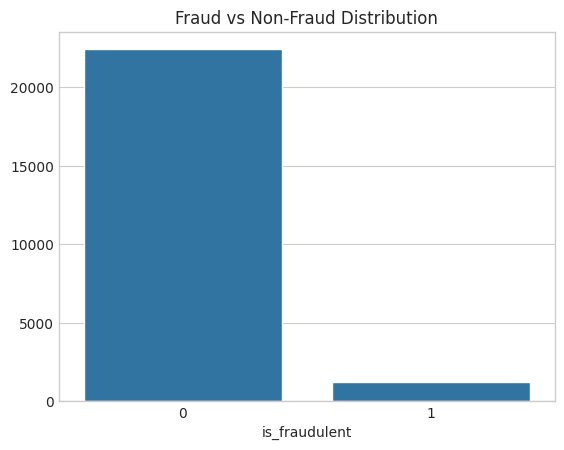

Fraud Ratio: 5.17051705170517%


In [218]:
# Visualize the distribution of the target variable
fraud_counts = df_eda['is_fraudulent'].value_counts()
print(fraud_counts)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()
print(f"Fraud Ratio: {df_eda['is_fraudulent'].mean() * 100}%")

Insight: The dataset is highly imbalanced. Only about 5.17% of the transactions are fraudulent. This is a critical finding. It means that a model that simply predicts "not fraudulent" every time will be 94.83% accurate. Therefore, accuracy is a poor metric for this problem. We must focus on metrics like Precision, Recall, F1-Score, and the AUC-ROC curve for classification task. Additionally, we might have to use methods like oversampling the minority class, undersampling the majority class or applying class weights.

## Transaction Amount by Fraud Status

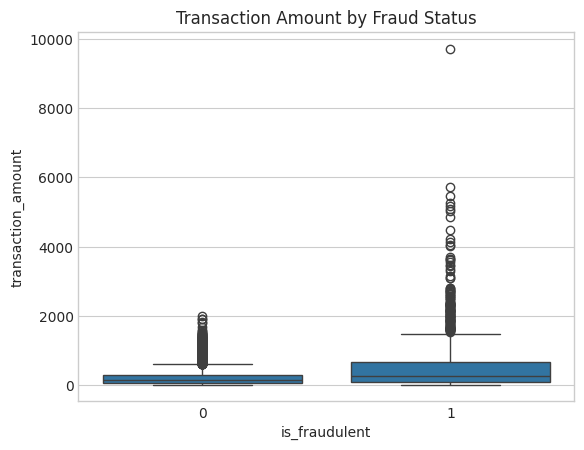

In [219]:
# Visualize transaction amounts for fraudulent vs non-fraudulent transactions
sns.boxplot(x='is_fraudulent', y='transaction_amount', data=df_eda)
plt.title("Transaction Amount by Fraud Status")
plt.show()

Insight: While the median transaction amount is slightly higher for fraudulent transactions, the most significant difference is in the variance and presence of high-value outliers. The fraudulent group has a much wider spread of transaction amounts and contains many more extreme high-value transactions. This suggests that Transaction Amount is a valuable feature, especially for identifying unusually large purchases.

## Distribution of Numeric Features

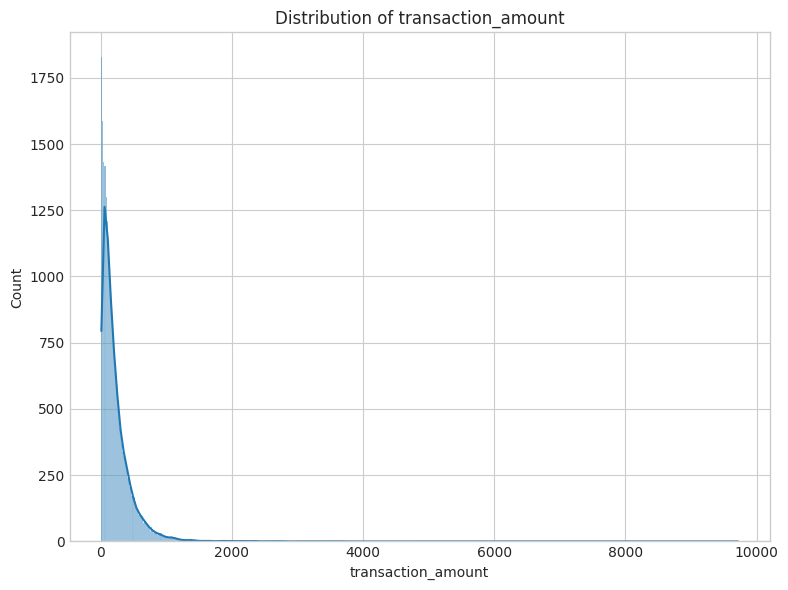

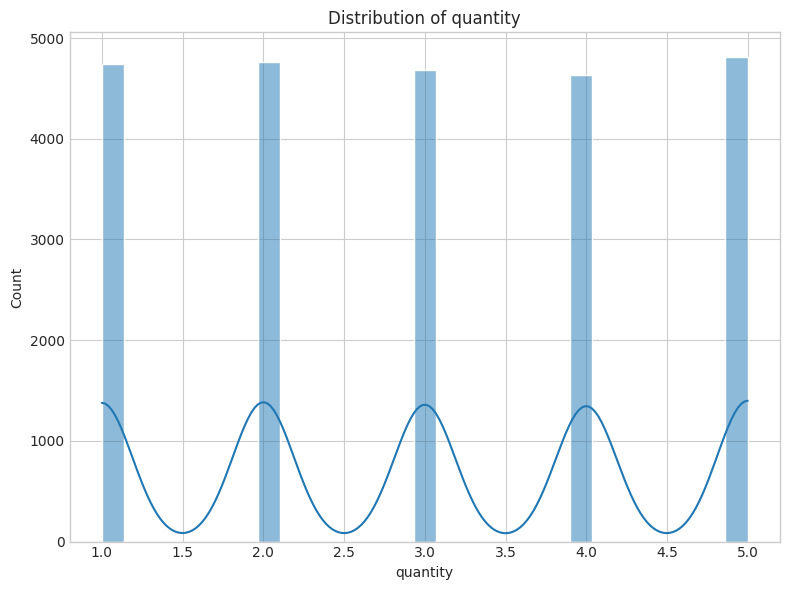

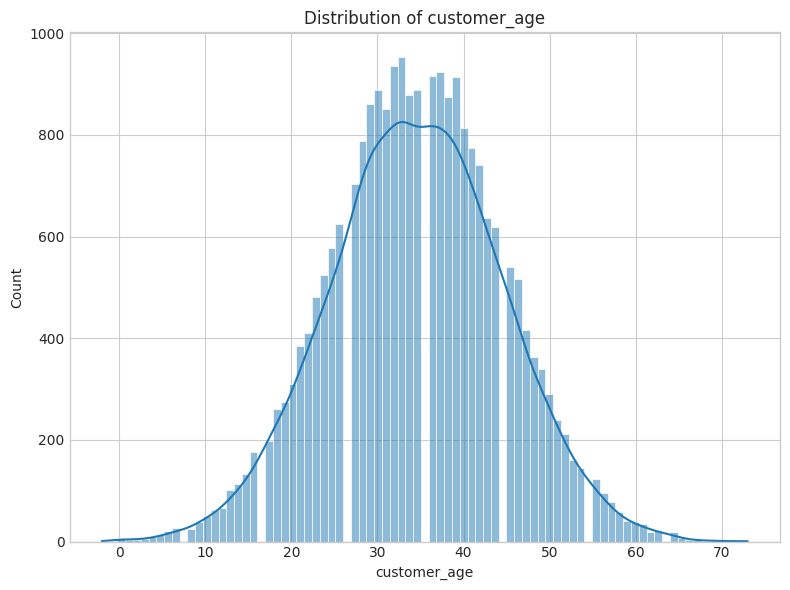

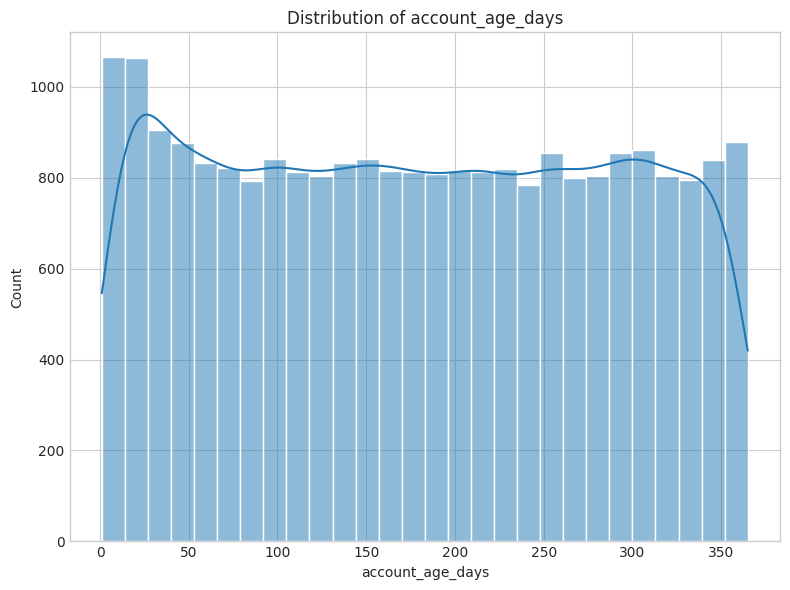

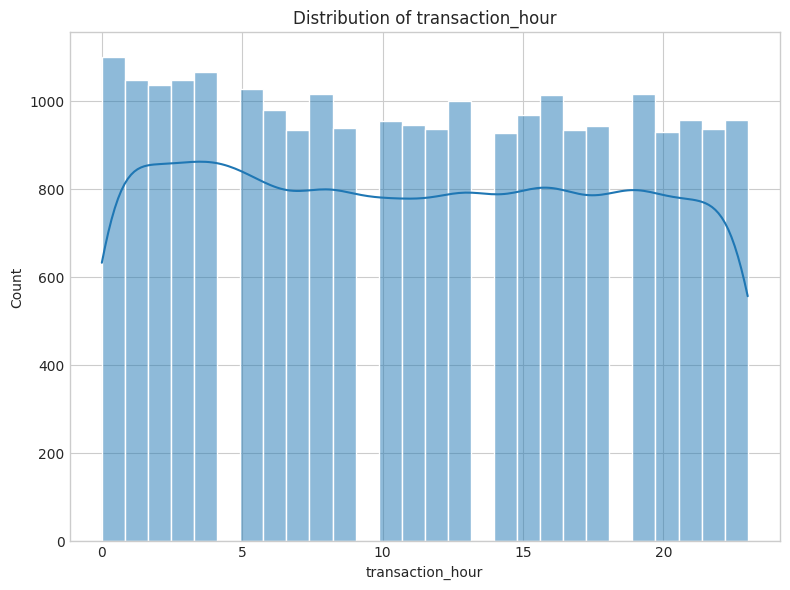

In [220]:
# Select numeric columns
numeric_cols = df_eda.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Plot distributions
for col in numeric_cols:
    if col == 'is_fraudulent':
        continue
    plt.figure(figsize=(8, 6))
    sns.histplot(df_eda[col], kde=True)
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
    plt.show()


Insight: The transaction amounts are heavily right-skewed, with the vast majority of transactions being of low value. This is typical for e-commerce data. For some machine learning models (like linear regression or models that assume normality), applying a log transformation to this feature can improve performance.

## Analyzing Temporal Patterns

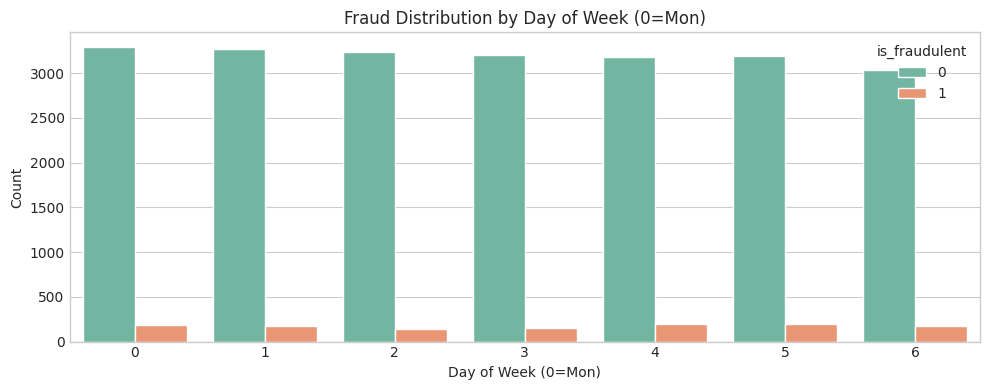

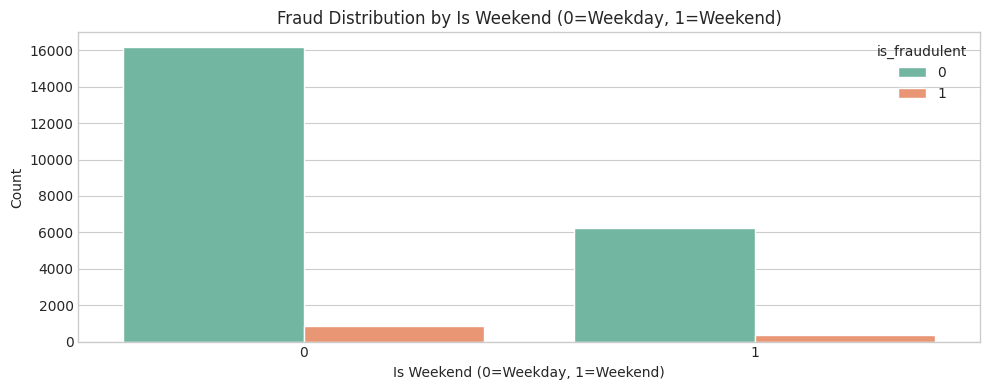

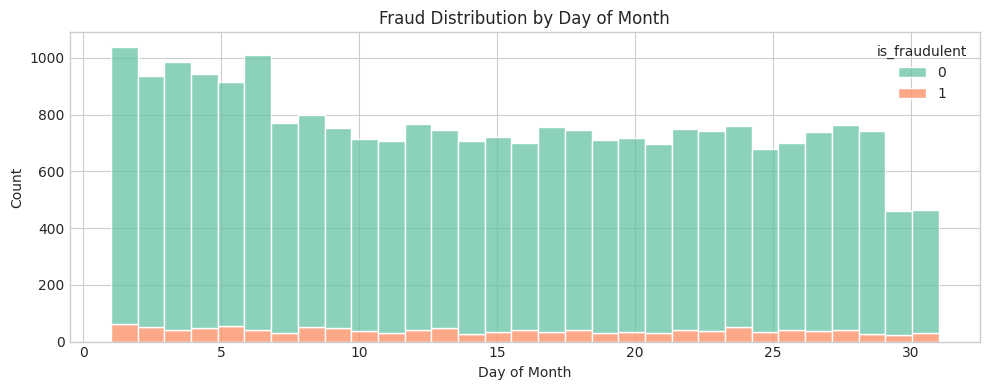

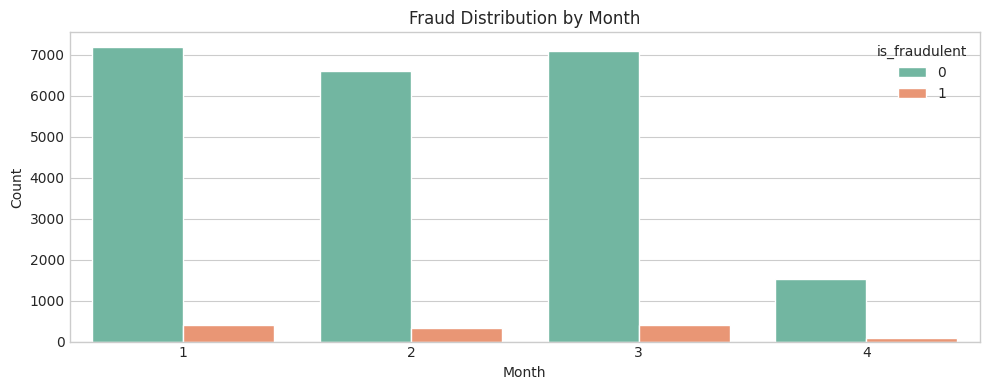

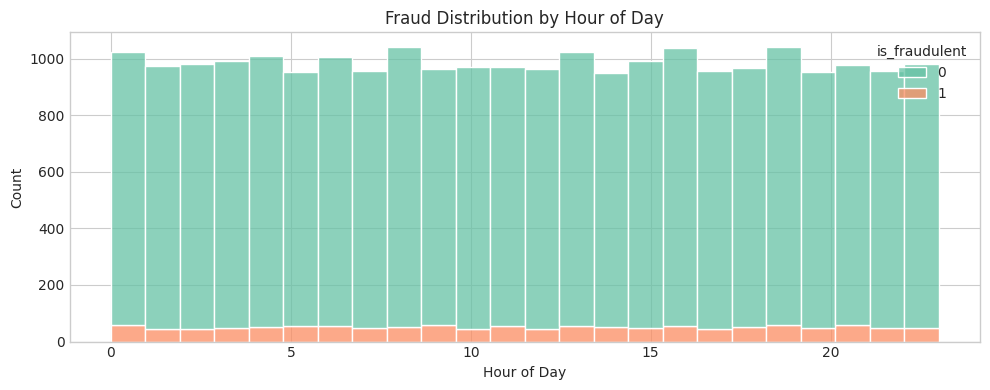

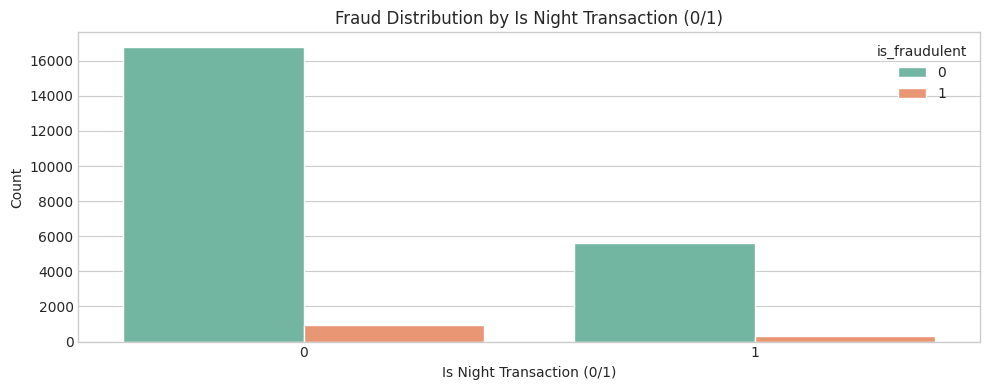


 Numerical Summary for day_of_week 
 day_of_week  fraud_rate  count  percentage
           0      0.0546   3482       14.73
           1      0.0508   3442       14.56
           2      0.0429   3378       14.29
           3      0.0453   3358       14.21
           4      0.0589   3380       14.30
           5      0.0564   3388       14.34
           6      0.0530   3206       13.57

 Numerical Summary for is_weekend 
 is_weekend  fraud_rate  count  percentage
          0      0.0505  17040        72.1
          1      0.0547   6594        27.9

 Numerical Summary for transaction_day 
 transaction_day  fraud_rate  count  percentage
               1      0.0597   1038        4.39
               2      0.0567    935        3.96
               3      0.0426    986        4.17
               4      0.0519    944        3.99
               5      0.0590    916        3.88
               6      0.0406   1011        4.28
               7      0.0403    770        3.26
               8     

In [221]:
def analyze_temporal_patterns(data, target_col='is_fraudulent'):
    """
    Extracts temporal features and produces 7 visualizations — one per feature.
    """

    # Ensure datetime
    data['transaction_date'] = pd.to_datetime(data['transaction_date'])

    # --- Extract Temporal Features ---
    data['day_of_week'] = data['transaction_date'].dt.weekday
    data['is_weekend'] = (data['day_of_week'] >= 5).astype(int)
    data['transaction_day'] = data['transaction_date'].dt.day
    data['transaction_month'] = data['transaction_date'].dt.month
    data['hour_of_day'] = data['transaction_date'].dt.hour
    data['is_night_transaction'] = data['hour_of_day'].isin([0,1,2,3,4,5]).astype(int)

    # Features to plot
    features = {
        "day_of_week": "Day of Week (0=Mon)",
        "is_weekend": "Is Weekend (0=Weekday, 1=Weekend)",
        "transaction_day": "Day of Month",
        "transaction_month": "Month",
        "hour_of_day": "Hour of Day",
        "is_night_transaction": "Is Night Transaction (0/1)"
    }

    # --- Plot each feature ---
    for col, title in features.items():
        plt.figure(figsize=(10,4))

        # Use histplot for features with many unique values
        if data[col].nunique() > 10:
            sns.histplot(data=data, x=col, hue='is_fraudulent',
                        multiple='stack', bins=data[col].nunique(), palette='Set2')
        else:
            sns.countplot(data=data, x=col, hue='is_fraudulent', palette='Set2')

        plt.title(f"Fraud Distribution by {title}")
        plt.xlabel(title)
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

    # --- Numerical Summary Tables ---
    summary_tables = {}

    for col in features.keys():
        summary = (
            data
            .groupby(col)['is_fraudulent']
            .agg(
                fraud_rate='mean',
                count='count'
            )
            .reset_index()
        )
        summary['percentage'] = (summary['count'] / len(data) * 100).round(2)
        summary['fraud_rate'] = summary['fraud_rate'].round(4)

        summary_tables[col] = summary

        print("\n=====================================")
        print(f" Numerical Summary for {col} ")
        print("=====================================")
        print(summary.to_string(index=False))


analyze_temporal_patterns(df_eda, target_col='is_fraudulent')

Insight: Fraudulent transactions appear fairly evenly distributed across days, hours, and months, but several subtle temporal patterns do emerge.

Day of Week: Fraud rates fluctuate mildly, with slightly elevated levels on Thursdays (0.0589), Saturdays (0.0564), and Mondays (0.0546). However, the variation is small, indicating no strong weekday-specific fraud pattern.

Weekend vs Weekday: Weekends show a slightly higher fraud rate (0.0547 vs 0.0505), suggesting increased fraud activity but not a dramatic shift.

Day of Month: Certain dates—including the 1st, 5th, 8th, 9th, 13th, 24th, and 31st—show moderately higher fraud rates. However, these spikes do not form a consistent pattern across months.

Month: Fraud is relatively stable across January–March (0.049–0.054). The lower fraud rate in April (0.0488) appears driven by a smaller sample size rather than true behavior.

Hour of Day: Fraud rates remain consistent across hours, with slightly higher activity around 0:00, 5:00, 9:00, 11:00, 19:00, and 21:00, though differences are marginal.

Night vs Day: Night transactions have similar fraud rates to daytime transactions (0.0509 vs 0.0520), indicating no meaningful night-time fraud spike.

Overall Insight:
Temporal features show weak but measurable signals — none of the time-based variables appear strong standalone predictors, but their small variations (e.g., weekday effects, certain days of month, slight weekend lift) can still contribute incremental predictive value when combined with customer, transactional, or behavioral features in a machine learning model.

## Analyzing Categorical Features

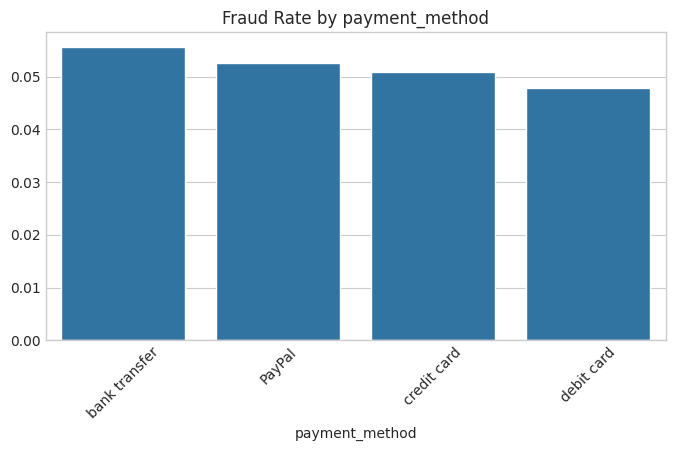

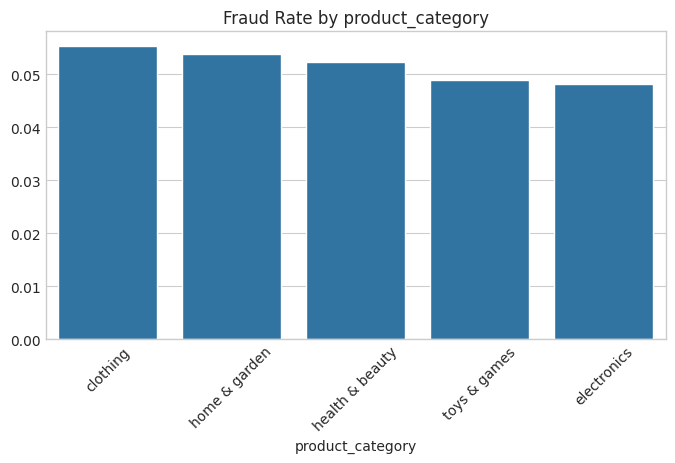

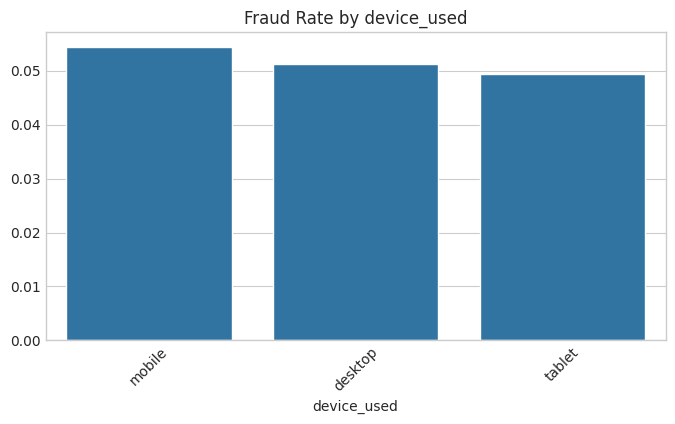

In [222]:
# Analyze fraud rates across categorical features
categorical_cols = ['payment_method', 'product_category', 'device_used']

for col in categorical_cols:
    fraud_rate = df_eda.groupby(col)['is_fraudulent'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    sns.barplot(x=fraud_rate.index, y=fraud_rate.values)
    plt.title(f"Fraud Rate by {col}")
    plt.xticks(rotation=45)
    plt.show()

Insight: The fraud rate is remarkably consistent (around 5%) across all categories for these features. For example, using a 'bank transfer' isn't significantly more or less risky than using a 'credit card'. This means these features, in their current form, have low predictive power on their own. However, they could still be useful in combination with other features (e.g., a high-value 'electronics' purchase on a 'mobile' device).

## Analyzing Customer Demographics

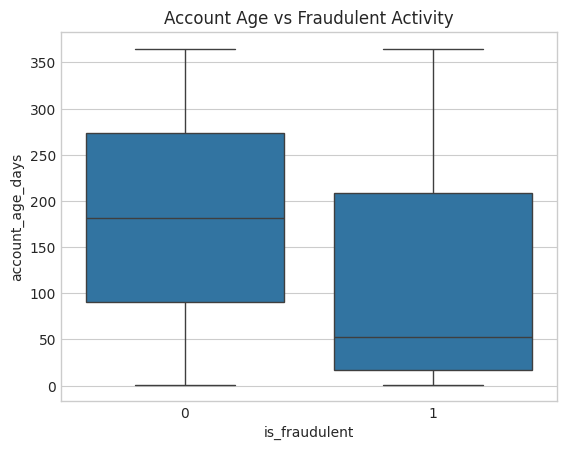

In [223]:
# Customer demographics analysis
sns.boxplot(x='is_fraudulent', y='account_age_days', data=df_eda)
plt.title("Account Age vs Fraudulent Activity")
plt.show()

Insight: This is a very strong signal. Fraudulent activity is heavily concentrated in newer accounts. The median account age for fraudulent transactions is significantly lower than for non-fraudulent ones. This is a classic fraud pattern: fraudsters create new accounts to burn before they get caught. account_age_days will be a crucial feature.

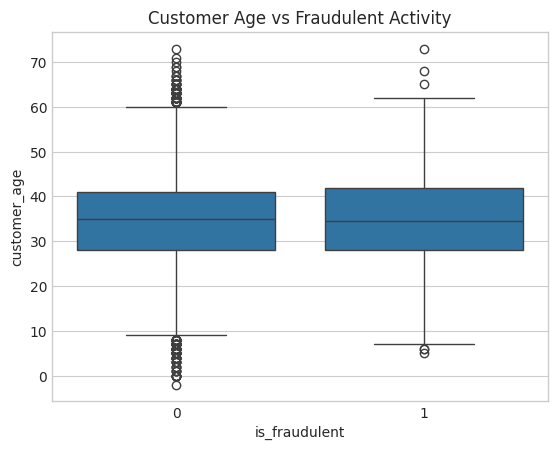

In [224]:
sns.boxplot(x='is_fraudulent', y='customer_age', data=df_eda)
plt.title("Customer Age vs Fraudulent Activity")
plt.show()

Insight: Unlike account age, the customer's actual age shows almost no difference between fraudulent and non-fraudulent transactions. The distributions are nearly identical. This feature is likely to have very low predictive power.

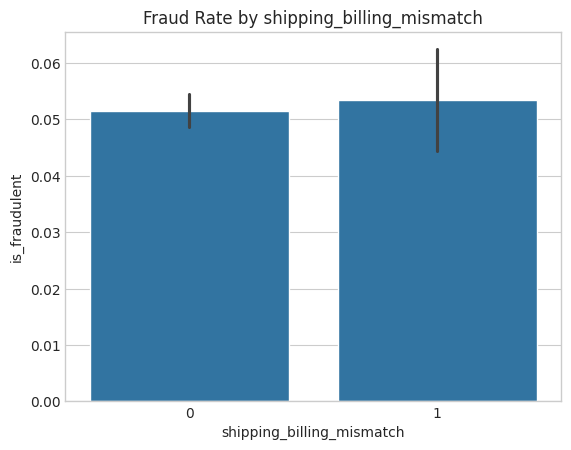

In [225]:
# Address mismatch analysis
df_eda['shipping_billing_mismatch'] = (df_eda['shipping_address'] != df_eda['billing_address']).astype(int)
sns.barplot(x='shipping_billing_mismatch', y='is_fraudulent', data=df_eda)
plt.title("Fraud Rate by shipping_billing_mismatch")
plt.show()

Insight: An address mismatch does not significantly increase the fraud rate in this dataset. This is somewhat surprising, as it's often a red flag. It could be that many legitimate customers (e.g., those sending gifts) have mismatches, diluting the signal from fraudsters.

## Correlation Between Numeric Features

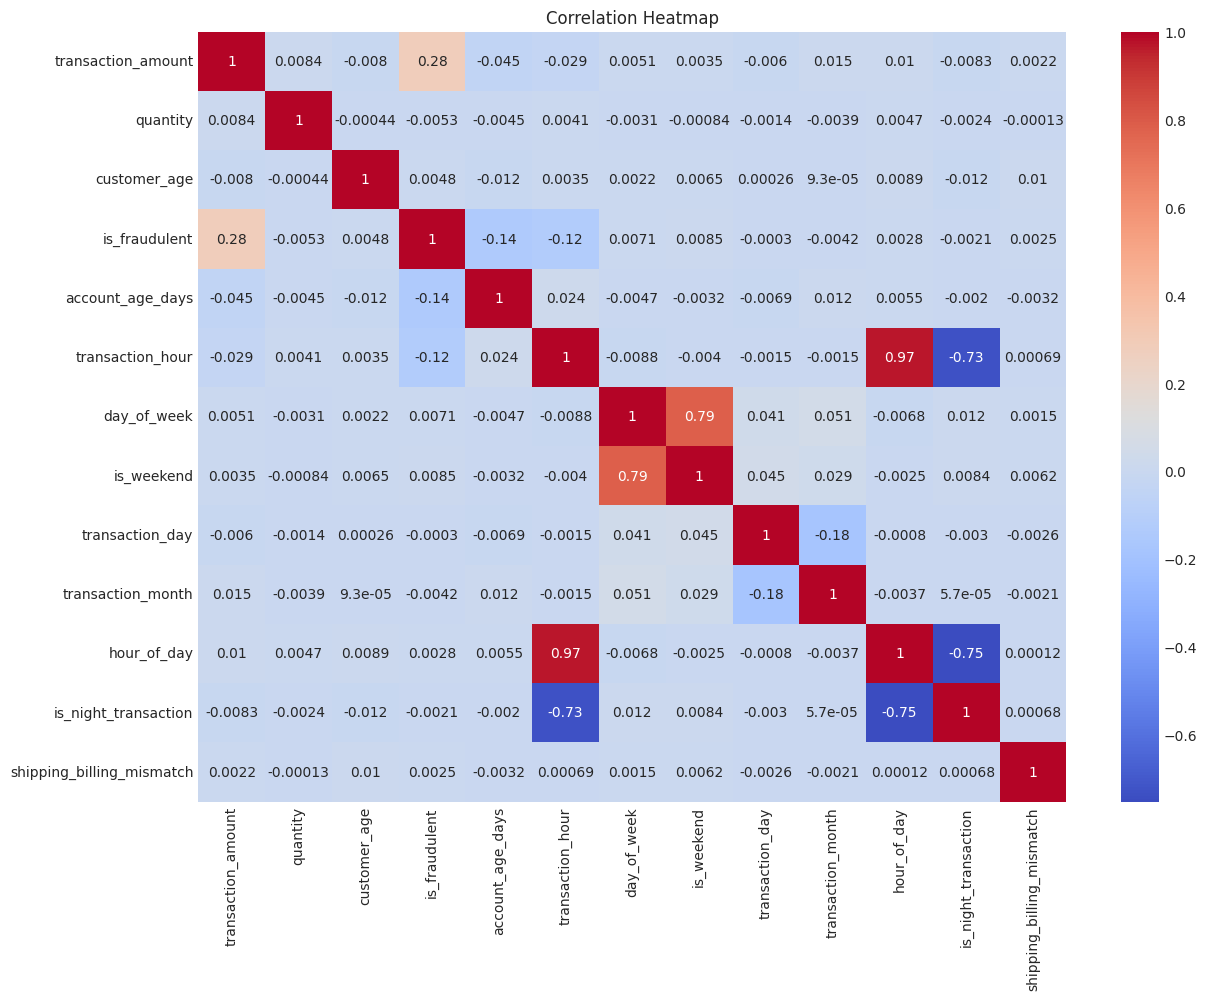

In [226]:
# Correlation analysis
numeric_cols = df_eda.select_dtypes(include=['int','float']).columns.tolist()
corr = df_eda[numeric_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

Insight: The heatmap confirms the previous findings numerically. hour_of_day has the strongest positive linear correlation (0.28) with fraud, and account_age_days has the strongest negative correlation (-0.14) followed by transaction_hour (-0.12). The other numeric features have near-zero correlation, indicating little to no linear relationship with fraud.

## Importance of categorical variables with target variable

In [227]:
def categorical_target_association(df_eda, target_col):
    results = []

    # Select categorical columns (exclude ID-like ones)
    categorical_cols = df_eda.select_dtypes(include=['object', 'category']).columns
    print(categorical_cols)

    for col in categorical_cols:
        # Skip columns that are unique identifiers
        if df_eda[col].nunique() > 50:
            continue

        unique_vals = df_eda[col].nunique()
        target = df_eda[target_col]

        # Binary categorical → use t-test
        if unique_vals == 2:
            groups = []
            for val in df_eda[col].unique():
                groups.append(target[df_eda[col] == val])

            t_stat, p_val = ttest_ind(groups[0], groups[1], equal_var=False)
            test_type = 't-test'

        # Multi-category → use chi-squared test
        else:
            contingency = pd.crosstab(df_eda[col], target)
            chi2, p_val, dof, expected = chi2_contingency(contingency)
            test_type = 'chi-square'

        results.append({
            'Feature': col,
            'Unique Values': unique_vals,
            'Test': test_type,
            'p-value': p_val
        })

    results_df = pd.DataFrame(results)
    results_df['Significant (p<0.05)'] = results_df['p-value'] < 0.05
    return results_df.sort_values('p-value')

results = categorical_target_association(df_eda, 'is_fraudulent')
print(results)

Index(['transaction_id', 'customer_id', 'payment_method', 'product_category',
       'customer_location', 'device_used', 'ip_address', 'shipping_address',
       'billing_address'],
      dtype='object')
            Feature  Unique Values        Test   p-value  Significant (p<0.05)
0    payment_method              4  chi-square  0.284269                 False
2       device_used              3  chi-square  0.356638                 False
1  product_category              5  chi-square  0.444859                 False


Insight: The Chi Square analysis showed that there is no statistical significance between the categorical variables and target variable as all p-values are above 0.05. This indicates that these features alone do not strongly differentiate between fraud and legitimate transactions. There is a need to combine these categorical features with other features.

## Benford's Law Analysis


--- Benford's Law Analysis on 'Transaction Amount' ---
Displaying Benford's Law plot. Close the plot window to continue the script...


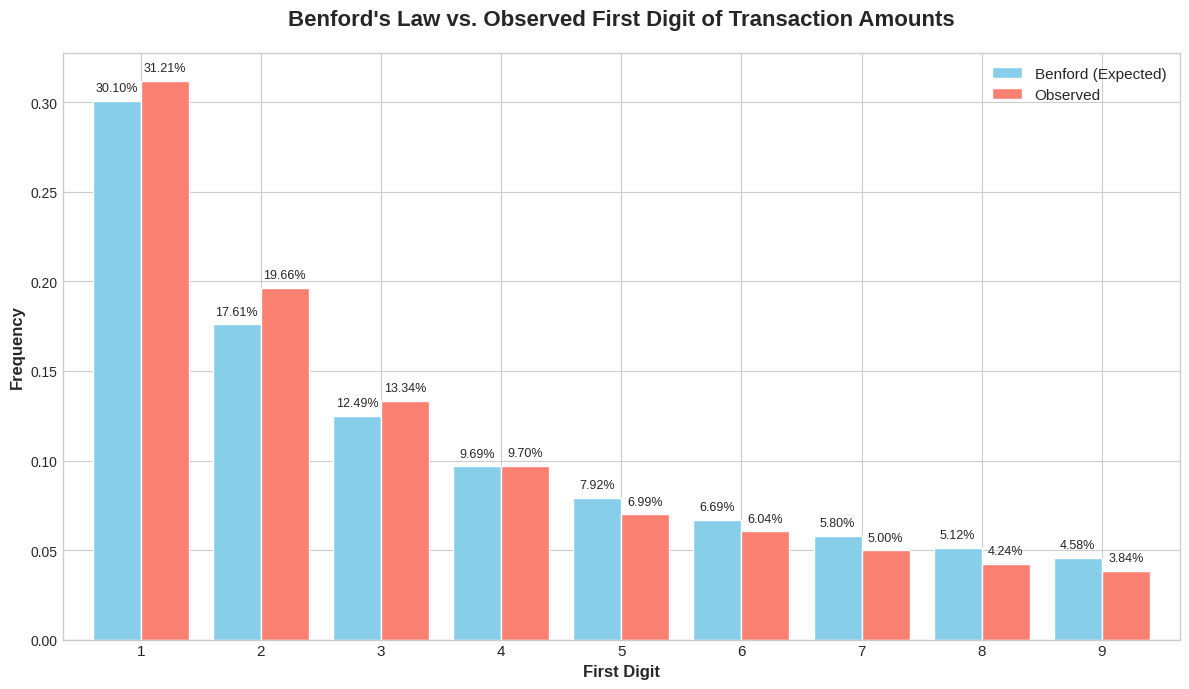

In [228]:
def benfords_law_analysis(data, column, title):
    """
    Performs Benford's Law analysis and displays the plot.
    The script will pause here until you close the plot window.
    """
    print(f"\n--- Benford's Law Analysis on '{title}' ---")

    # 1. Isolate the first digit
    first_digits = data[column][data[column] > 0].astype(str).str[0].astype(int)

    # 2. Calculate observed frequency
    observed_freq = first_digits.value_counts(normalize=True).sort_index()

    # 3. Calculate expected Benford frequency
    benford_digits = np.arange(1, 10)
    expected_freq = np.log10(1 + 1/benford_digits)

    # 4. Create a DataFrame for plotting
    analysis_df = pd.DataFrame({
        'Digit': benford_digits,
        'Benford (Expected)': expected_freq
    }).set_index('Digit')
    analysis_df = analysis_df.join(observed_freq.rename('Observed')).fillna(0)

    # 5. Generate and style the plot
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 7))
    analysis_df.plot(kind='bar', ax=ax, width=0.8, color=['skyblue', 'salmon'])

    ax.set_title("Benford's Law vs. Observed First Digit of Transaction Amounts", fontsize=16, pad=20, weight='bold')
    ax.set_xlabel("First Digit", fontsize=12, weight='bold')
    ax.set_ylabel("Frequency", fontsize=12, weight='bold')
    ax.tick_params(axis='x', rotation=0, labelsize=11)
    ax.legend(fontsize=11)

    # Add percentage labels
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2%}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 9), textcoords='offset points', fontsize=9)

    plt.tight_layout()

    # 6. Display the plot. The script will pause here.
    print("Displaying Benford's Law plot. Close the plot window to continue the script...")
    plt.show()

# Call the function to display the plot
benfords_law_analysis(df_eda, 'transaction_amount', 'Transaction Amount')

# More indepth EDA

## Are high-value fraudulent transactions more common in specific product categories?

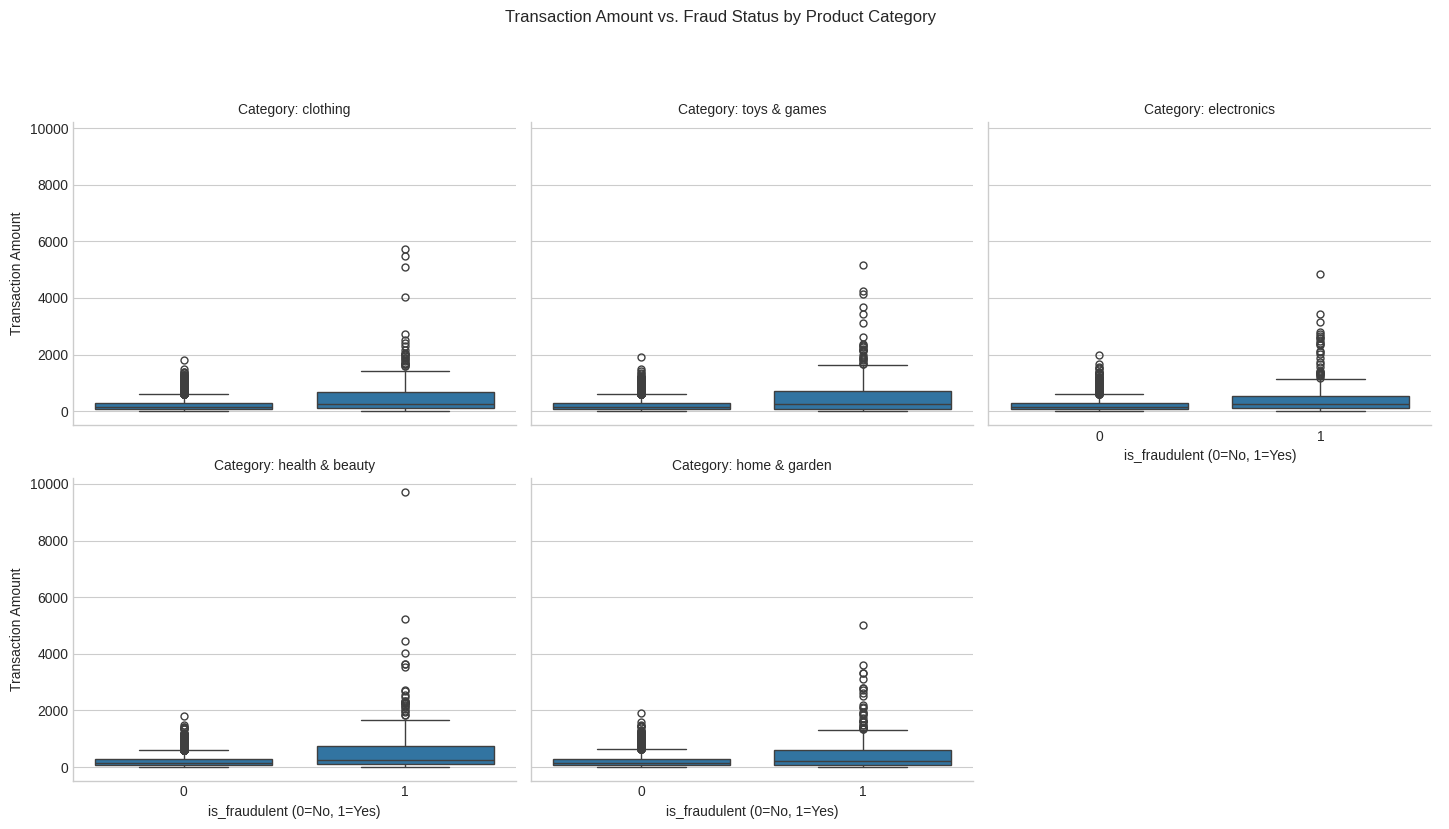

In [229]:
# Create a faceted boxplot
g = sns.catplot(
    x='is_fraudulent',
    y='transaction_amount',
    col='product_category',
    data=df_eda,
    kind='box',
    col_wrap=3, # Wraps the plots into 3 columns
    height=4,
    aspect=1.2
)

# Set titles and labels for clarity
g.fig.suptitle('Transaction Amount vs. Fraud Status by Product Category', y=1.03)
g.set_axis_labels("is_fraudulent (0=No, 1=Yes)", "Transaction Amount")
g.set_titles("Category: {col_name}")

# To prevent clipping of the suptitle
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

Insight: The general pattern holds true across all categories: fraudulent transactions (1) have a higher median amount and significantly more high-value outliers than non-fraudulent transactions (0).

## How many unique IPs/Addresses does a customer use? (Fraud rings)

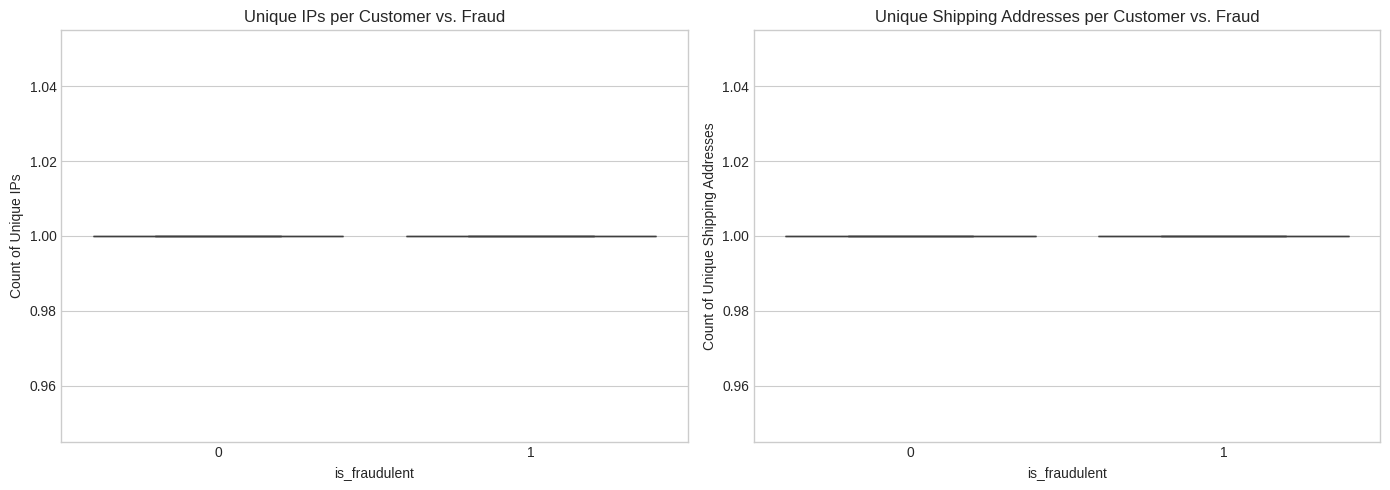

In [230]:
# Group by Customer ID and count unique IPs and Shipping Addresses
customer_behavior = df_eda.groupby('customer_id').agg(
    unique_ips_per_customer=pd.NamedAgg(column='ip_address', aggfunc='nunique'),
    unique_shipping_add_per_customer=pd.NamedAgg(column='shipping_address', aggfunc='nunique')
).reset_index()

# Merge this back into the main dataframe
df_eda = pd.merge(df_eda, customer_behavior, on='customer_id', how='left')

# Visualize the findings
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.boxplot(x='is_fraudulent', y='unique_ips_per_customer', data=df_eda, ax=axes[0])
axes[0].set_title('Unique IPs per Customer vs. Fraud')
axes[0].set_ylabel('Count of Unique IPs')

sns.boxplot(x='is_fraudulent', y='unique_shipping_add_per_customer', data=df_eda, ax=axes[1])
axes[1].set_title('Unique Shipping Addresses per Customer vs. Fraud')
axes[1].set_ylabel('Count of Unique Shipping Addresses')

plt.tight_layout()
plt.show()

Insight: Every customer has exactly one unique IP and one unique shipping address, and consequently, no IP addresses are ever shared.
This is completely unrealistic and is the strongest evidence yet that this is a heavily sanitized or synthetic dataset. In the real world, customers use multiple devices (phone, work PC, home laptop) and send gifts to different addresses. Fraud rings are often identified by many accounts using the same IP.

## How many distinct values are there for each object column

In [231]:
# Count number of distinct values for each object column
distinct_df = df.select_dtypes(include='object').nunique().reset_index()
distinct_df.columns = ['column', 'distinct_count']
print(distinct_df)
print('\ndf_eda shape:')
print(df_eda.shape)


              column  distinct_count
0     transaction_id           23634
1        customer_id           23634
2     payment_method               4
3   product_category               5
4  customer_location           14868
5        device_used               3
6         ip_address           23634
7   shipping_address           23634
8    billing_address           23634

df_eda shape:
(23634, 25)


Insight: Some columns such as transaction_id, customer_id, ip_address, shipping_address, billing_address may not be useful alone as they have the same cardinality as the shape of df

## Compare a customer's current transaction to their own past behavior.

/tmp/ipython-input-3646768960.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_eda['customer_avg_spend_before_tx'].fillna(0, inplace=True)


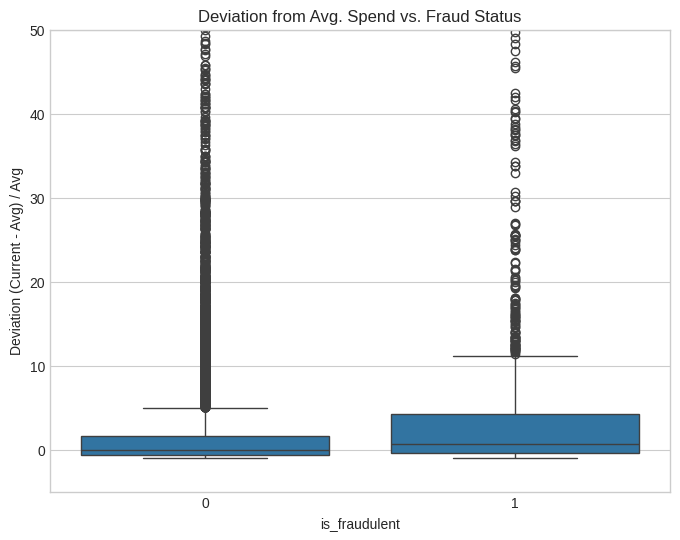

In [232]:
# Calculate a customer's expanding average spend *before* the current transaction
# shift(1) is crucial to prevent data leakage (using the current transaction's value in its own historical average)
df_eda['customer_avg_spend_before_tx'] = df_eda.groupby('customer_id')['transaction_amount'] \
                                           .expanding(min_periods=1).mean().shift(1) \
                                           .reset_index(level=0, drop=True)

# Fill NaN for the very first transaction of each customer
df_eda['customer_avg_spend_before_tx'].fillna(0, inplace=True)

# Create the deviation feature
# Add a small epsilon (1) to the denominator to avoid division by zero for the first transaction
df_eda['amount_deviation'] = (df_eda['transaction_amount'] - df_eda['customer_avg_spend_before_tx']) / (df_eda['customer_avg_spend_before_tx'] + 1)

# Visualize the deviation
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_fraudulent', y='amount_deviation', data=df_eda)
plt.title('Deviation from Avg. Spend vs. Fraud Status')
plt.ylabel('Deviation (Current - Avg) / Avg')
# Outliers can skew the plot, so let's limit the y-axis for better visibility
plt.ylim(-5, 50)
plt.show()

Insight: amount_deviation is likely to be one of the most important predictors. It successfully captures a core behavioral dynamic of fraud as the separation between the two classes is visually very clear.

# Feature Engineering

In [233]:
# --- ELITE & LEAKAGE-PROOF FEATURE ENGINEERING ---
df['hour_of_day'] = df['transaction_date'].dt.hour
df['day_of_week'] = df['transaction_date'].dt.dayofweek
df['is_night_transaction'] = df['hour_of_day'].isin([0, 1, 2, 3, 4, 5]).astype(int)
df['shipping_billing_mismatch'] = (df['shipping_address'] != df['billing_address']).astype(int)

df['location_frequency'] = df.groupby('customer_location')['customer_location'].transform('count')

# Calculate category average amount ONCE and store it for reuse
df['category_avg_amount'] = df.groupby('product_category')['transaction_amount'].transform('mean')
df['amount_vs_category_avg'] = df['transaction_amount'] / (df['category_avg_amount'] + 1e-6)
df['amount_to_account_age_ratio'] = df['transaction_amount'] / (df['account_age_days'] + 1)
df.fillna(0, inplace=True)

# --- DATA PREPARATION FOR MODELING ---
features_to_drop = ['transaction_id', 'customer_id', 'transaction_date', 'shipping_address', 'billing_address', 'is_fraudulent',
                      'customer_location', 'ip_address', 'category_avg_amount'] # Drop helper column
X = df.drop(columns=features_to_drop)
y = df['is_fraudulent']
categorical_features = X.select_dtypes(include=['object', 'category']).columns
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
numerical_features = X.select_dtypes(include=np.number).columns
scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

# --- Log skewed numerical features for Logistic Regression ---
# Create a copy of X_train and X_test for Logistic Regression
X_train_lr, X_test_lr = X_train.copy(), X_test.copy()

# Log-transform transaction_amount
X_train_lr['transaction_amount'] = np.log1p(X_train_lr['transaction_amount'])
X_test_lr['transaction_amount'] = np.log1p(X_test_lr['transaction_amount'])
scaler_lr = StandardScaler()
X_train_lr[numerical_features] = scaler_lr.fit_transform(X_train_lr[numerical_features])
X_test_lr[numerical_features] = scaler_lr.transform(X_test_lr[numerical_features])

print(X_train.shape, X_test.shape)


(18907, 21) (4727, 21)


# Model Training

## Helper Functions

In [234]:
def evaluate_model(model, X_test, y_test, y_pred=None, y_proba=None, top_n_features=20, target_names=['Not Fraud', 'Fraud']):
    """
    General model evaluation: metrics, confusion matrix, and feature importance.

    Args:
        model : trained classifier
        X_test (pd.DataFrame): test features
        y_test (array-like): true labels
        y_pred (array-like, optional): predicted labels; if None, uses model.predict(X_test)
        y_proba (array-like, optional): predicted probabilities for positive class; if None, tries model.predict_proba
        top_n_features (int): number of top features to show in importance plot
        target_names (list): names for classification report & confusion matrix
    """
    # --- Predictions ---
    if y_pred is None:
        y_pred = model.predict(X_test)

    if y_proba is None:
        try:
            y_proba = model.predict_proba(X_test)[:, 1]
        except:
            y_proba = None

    # --- Metrics ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred, target_names=target_names))

    if y_proba is not None:
        print("\n--- ROC AUC / AUPRC ---")
        print(f"AUPRC Score: {average_precision_score(y_test, y_proba):.4f}")
        print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # --- Feature Importance ---
    importance = None
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importance = model.coef_[0] if model.coef_.ndim > 1 else model.coef_

    if importance is not None:
        feature_importance_df = pd.DataFrame({
            'feature': X_test.columns,
            'importance': importance
        }).sort_values('importance', ascending=False).head(top_n_features)

        top_features = feature_importance_df['feature'].tolist()    # For potential further analysis
        plt.figure(figsize=(10,8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top {top_n_features} Feature Importances')
        plt.show()
        return top_features

## Logistic Regression

In [235]:
# --- HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial, X, y, random_seed):
    C = trial.suggest_float('C', 1e-4, 1e2, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

    class_weight = trial.suggest_categorical('class_weight', ['balanced', None])

    solver = 'liblinear'

    model = LogisticRegression(
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight=class_weight,
        max_iter=2000,
        random_state=random_seed
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    score = cross_val_score(
        model,
        X,
        y,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    return score.mean()

print("Starting Hyperparameter Tuning (Optuna TPE Sampler)...")
print("Tuning 'C', 'penalty', and 'class_weight'.")

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))

study.optimize(
    lambda trial: objective(trial, X_train_lr, y_train, RANDOM_STATE),

    n_trials=100,
    show_progress_bar=True
)
print("Tuning complete")

[I 2025-11-19 13:37:56,850] A new study created in memory with name: no-name-dbf65f1a-ae5c-4320-bfea-c099cdf5775c


Starting Hyperparameter Tuning (Optuna TPE Sampler)...
Tuning 'C', 'penalty', and 'class_weight'.


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-11-19 13:38:01,899] Trial 0 finished with value: 0.8157607701302398 and parameters: {'C': 0.017670169402947963, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607701302398.
[I 2025-11-19 13:38:02,187] Trial 1 finished with value: 0.7528554203037242 and parameters: {'C': 0.0008629132190071859, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.8157607701302398.
[I 2025-11-19 13:38:02,391] Trial 2 finished with value: 0.5 and parameters: {'C': 0.00013289448722869195, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607701302398.
[I 2025-11-19 13:38:02,999] Trial 3 finished with value: 0.8047569249355284 and parameters: {'C': 0.0012601639723276807, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.8157607701302398.
[I 2025-11-19 13:38:03,571] Trial 4 finished with value: 0.8101340070361409 and parameters: {'C': 0.4689400963537689, 'penalty': 'l2', 'class_weight': None}. Bes

In [236]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_roc_auc = study.best_value

best_model_lr = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],

    class_weight=best_params['class_weight'],

    solver='liblinear',
    max_iter=2000,
    random_state=RANDOM_STATE
)

best_model_lr.fit(X_train_lr, y_train)

print("OPTUNA TUNING RESULTS")
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST ROC AUC SCORE (from Cross-Validation): {best_roc_auc:.4f}")

OPTUNA TUNING RESULTS
BEST PARAMETERS FOUND: {'C': 0.0061559254454280465, 'penalty': 'l1', 'class_weight': 'balanced'}
BEST ROC AUC SCORE (from Cross-Validation): 0.8176



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.84      0.90      4483
       Fraud       0.18      0.64      0.28       244

    accuracy                           0.83      4727
   macro avg       0.58      0.74      0.59      4727
weighted avg       0.94      0.83      0.87      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.5108
ROC AUC Score: 0.8245


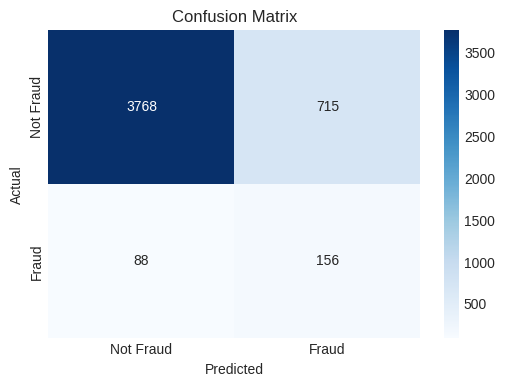

/tmp/ipython-input-1215520620.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


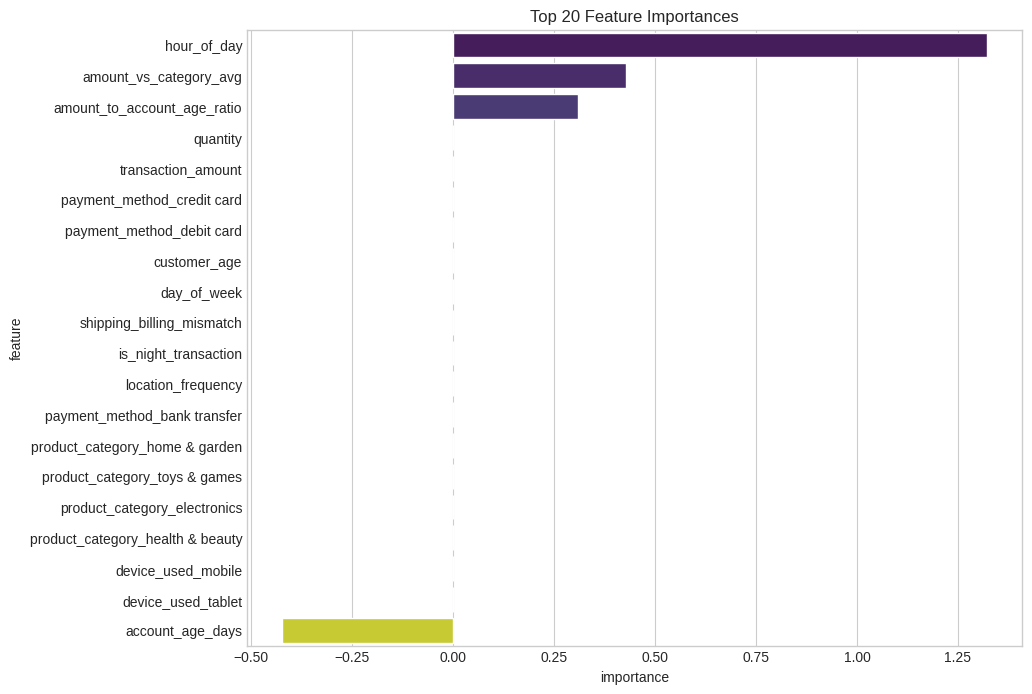

In [237]:
# --- EVALUATE THE MODEL ---
y_pred_lr = best_model_lr.predict(X_test_lr)
y_proba_lr = best_model_lr.predict_proba(X_test_lr)[:, 1]
top_features_lr = evaluate_model(best_model_lr, X_test_lr, y_test, y_pred=y_pred_lr, y_proba=y_proba_lr)

## XGBoost

In [238]:
# --- XGBOOST HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial):
    scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

    params = {
        'objective': 'binary:logistic', 'eval_metric': 'aucpr', 'random_state': RANDOM_STATE,
        'scale_pos_weight': scale_pos_weight,
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'max_depth': trial.suggest_int('max_depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }

    # ---- K-FOLD ----
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = xgb.XGBClassifier(**params, use_label_encoder=False)
        model.fit(X_tr, y_tr, verbose=False)

        y_prob = model.predict_proba(X_val)[:, 1]

        # Evaluate PR-AUC (best for imbalanced fraud data)
        cv_scores.append(average_precision_score(y_val, y_prob))

    # Return mean CV score
    return np.mean(cv_scores)

study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study.optimize(objective, n_trials=50) # Run 50 trials to find the best params

[I 2025-11-19 13:38:51,203] A new study created in memory with name: no-name-7d8f07be-7212-449a-8622-45cd6c982364
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:38:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:38:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:38:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:38:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration

In [239]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_roc_auc = study.best_value

scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)
best_model_xgb = xgb.XGBClassifier(
    objective='binary:logistic', eval_metric='aucpr', scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE, use_label_encoder=False, **best_params
)
best_model_xgb.fit(X_train, y_train)

print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST ROC AUC SCORE (from Cross-Validation): {best_roc_auc:.4f}")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [13:42:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


BEST PARAMETERS FOUND: {'n_estimators': 649, 'max_depth': 4, 'learning_rate': 0.012971023455171092, 'subsample': 0.9466942892770267, 'colsample_bytree': 0.7314826360491571, 'gamma': 3.076111601294503, 'min_child_weight': 10}
BEST ROC AUC SCORE (from Cross-Validation): 0.5843



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.90      0.94      4483
       Fraud       0.27      0.70      0.39       244

    accuracy                           0.89      4727
   macro avg       0.63      0.80      0.66      4727
weighted avg       0.95      0.89      0.91      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.6038
ROC AUC Score: 0.8536


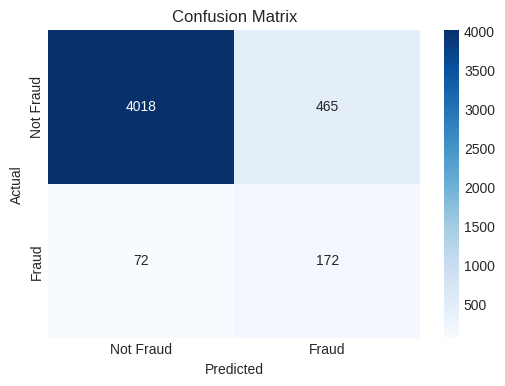

/tmp/ipython-input-1215520620.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


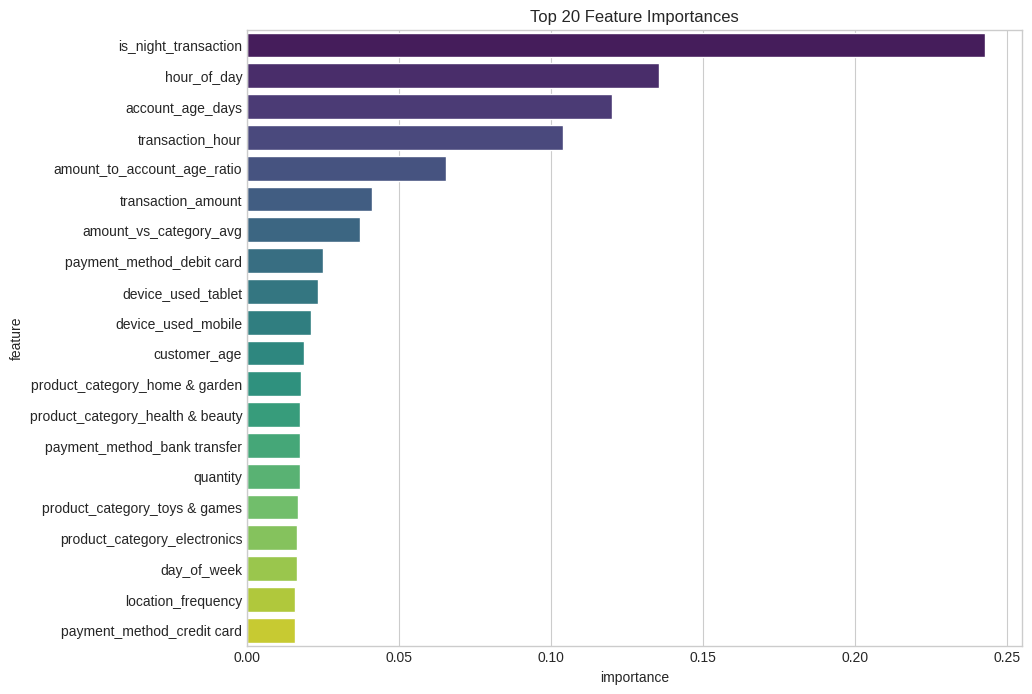

In [240]:
# --- EVALUATE THE MODEL ---
y_pred_xgb = best_model_xgb.predict(X_test)
y_proba_xgb = best_model_xgb.predict_proba(X_test)[:, 1]
top_features_xgb = evaluate_model(best_model_xgb, X_test, y_test, y_pred_xgb, y_proba_xgb)

## LightGBM

In [241]:
# --- LGB HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial):
    scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

    params = {
        'objective': 'binary',
        'metric': 'average_precision',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': RANDOM_STATE,
        'scale_pos_weight': scale_pos_weight,

        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),

        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),

        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, valid_idx in kf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_tr, y_tr)
        y_prob = model.predict_proba(X_val)[:, 1]

        score = average_precision_score(y_val, y_prob)
        cv_scores.append(score)

    return np.mean(cv_scores)

print("Starting LightGBM Hyperparameter Tuning (Custom K-Fold)...")
study_lgbm = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_STATE))
study_lgbm.optimize(objective, n_trials=50)

print("Tuning complete.")
print("Best params:", study_lgbm.best_params)
print("Best PR-AUC:", study_lgbm.best_value)

[I 2025-11-19 13:42:36,117] A new study created in memory with name: no-name-15526d39-6934-4e1e-a5d5-45f6411a08e6


Starting LightGBM Hyperparameter Tuning (Custom K-Fold)...


[I 2025-11-19 13:42:40,057] Trial 0 finished with value: 0.5494685986780856 and parameters: {'n_estimators': 500, 'learning_rate': 0.28570714885887566, 'num_leaves': 115, 'max_depth': 8, 'min_child_samples': 19, 'subsample': 0.662397808134481, 'colsample_bytree': 0.6232334448672797, 'reg_alpha': 0.6245760287469893, 'reg_lambda': 0.002570603566117598}. Best is trial 0 with value: 0.5494685986780856.
[I 2025-11-19 13:42:58,794] Trial 1 finished with value: 0.5704587283290884 and parameters: {'n_estimators': 767, 'learning_rate': 0.01596950334578271, 'num_leaves': 147, 'max_depth': 11, 'min_child_samples': 25, 'subsample': 0.6727299868828402, 'colsample_bytree': 0.6733618039413735, 'reg_alpha': 5.472429642032198e-06, 'reg_lambda': 0.00052821153945323}. Best is trial 1 with value: 0.5704587283290884.
[I 2025-11-19 13:43:04,265] Trial 2 finished with value: 0.5663510462791475 and parameters: {'n_estimators': 545, 'learning_rate': 0.09445645065743215, 'num_leaves': 100, 'max_depth': 4, 'min_

Tuning complete.
Best params: {'n_estimators': 240, 'learning_rate': 0.1082167253824592, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 32, 'subsample': 0.849582819188754, 'colsample_bytree': 0.6676536991649815, 'reg_alpha': 8.860597195860256e-06, 'reg_lambda': 0.0011860177175706038}
Best PR-AUC: 0.5801788824172732


In [242]:
# Retrieve and display the best parameters and score
best_params = study_lgbm.best_params
best_pr_auc = study_lgbm.best_value

scale_pos_weight = y_train.value_counts().get(0, 1) / y_train.value_counts().get(1, 1)

best_model_lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='average_precision',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbosity=-1,
    **best_params
)

best_model_lgbm.fit(X_train, y_train)

print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST PR-AUC SCORE (from Cross-Validation): {best_pr_auc:.4f}")

BEST PARAMETERS FOUND: {'n_estimators': 240, 'learning_rate': 0.1082167253824592, 'num_leaves': 36, 'max_depth': 3, 'min_child_samples': 32, 'subsample': 0.849582819188754, 'colsample_bytree': 0.6676536991649815, 'reg_alpha': 8.860597195860256e-06, 'reg_lambda': 0.0011860177175706038}
BEST PR-AUC SCORE (from Cross-Validation): 0.5802



--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.98      0.90      0.94      4483
       Fraud       0.28      0.70      0.40       244

    accuracy                           0.89      4727
   macro avg       0.63      0.80      0.67      4727
weighted avg       0.95      0.89      0.91      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.6001
ROC AUC Score: 0.8397


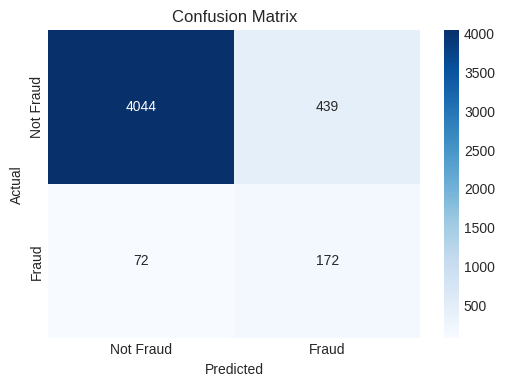

/tmp/ipython-input-1215520620.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


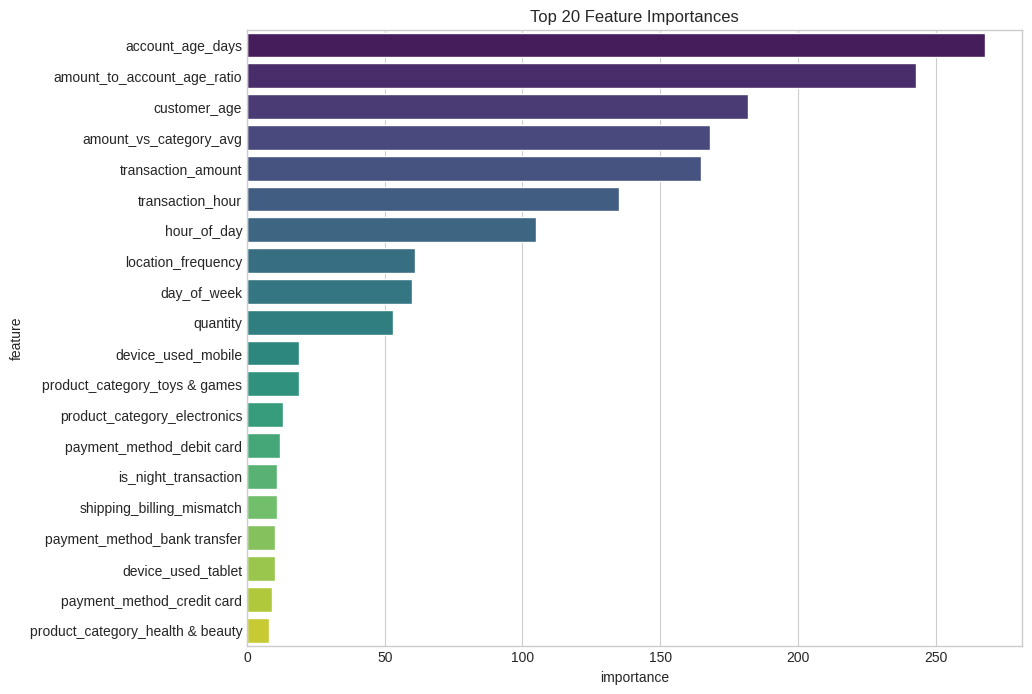

In [243]:
# --- EVALUATE THE MODEL ---
y_pred_lgbm = best_model_lgbm.predict(X_test)
y_proba_lgbm = best_model_lgbm.predict_proba(X_test)[:, 1]

top_features_lgbm = evaluate_model(best_model_lgbm, X_test, y_test, y_pred_lgbm, y_proba_lgbm)

## Unsupervised Learning: Isolation Forest

In [244]:
# --- Isolation Forest HYPERPARAMETER TUNING WITH OPTUNA ---
def objective(trial, X, y, random_seed):
    n_estimators = trial.suggest_int('n_estimators', 100, 600)
    max_samples = trial.suggest_categorical('max_samples', ['auto', 0.5, 0.75, 1.0])
    contamination = trial.suggest_float('contamination', 0.001, 0.05, log=True)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

    scores = []

    for train_idx, val_idx in cv.split(X, y):
        X_tr = X.iloc[train_idx]
        X_val = X.iloc[val_idx]
        y_val = y.iloc[val_idx]

        model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            max_features=max_features,
            random_state=random_seed,
            n_jobs=-1
        )

        model.fit(X_tr)

        y_pred_raw = model.predict(X_val)

        y_pred_binary = np.where(y_pred_raw == -1, 1, 0)

        score = f1_score(y_val, y_pred_binary)
        scores.append(score)

    return np.mean(scores)

print("Starting Isolation Forest Hyperparameter Tuning (Optuna TPE Sampler)...")
print("Tuning 'n_estimators', 'contamination', etc. based on F1 Score.")

study = optuna.create_study(direction='maximize')
study.optimize(
    lambda trial: objective(trial, X_train, y_train, RANDOM_STATE),
    n_trials=50,
    show_progress_bar=True
)

print("Tuning complete.")

[I 2025-11-19 13:46:23,844] A new study created in memory with name: no-name-8bfc8adb-615b-4a7d-b740-ac5ccd2cb07e


Starting Isolation Forest Hyperparameter Tuning (Optuna TPE Sampler)...
Tuning 'n_estimators', 'contamination', etc. based on F1 Score.


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-11-19 13:46:33,606] Trial 0 finished with value: 0.17675198192140018 and parameters: {'n_estimators': 206, 'max_samples': 1.0, 'contamination': 0.0071763227797159825, 'max_features': 0.646578714906161}. Best is trial 0 with value: 0.17675198192140018.
[I 2025-11-19 13:47:01,615] Trial 1 finished with value: 0.09312762291700435 and parameters: {'n_estimators': 588, 'max_samples': 1.0, 'contamination': 0.0026191721216764275, 'max_features': 0.9993625090971952}. Best is trial 0 with value: 0.17675198192140018.
[I 2025-11-19 13:47:06,837] Trial 2 finished with value: 0.041689382434809616 and parameters: {'n_estimators': 123, 'max_samples': 0.75, 'contamination': 0.001295530724518766, 'max_features': 0.6947766817054161}. Best is trial 0 with value: 0.17675198192140018.
[I 2025-11-19 13:47:13,270] Trial 3 finished with value: 0.1792846268140899 and parameters: {'n_estimators': 122, 'max_samples': 1.0, 'contamination': 0.008373349404018078, 'max_features': 0.6602677040137277}. Best is

In [245]:
# Retrieve and display the best parameters and score
best_params = study.best_params
best_f1 = study.best_value

best_model = IsolationForest(
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    contamination=best_params['contamination'],
    max_features=best_params['max_features'],
    random_state=RANDOM_STATE,
    n_jobs=-1
)
best_model.fit(X_train)

print("OPTUNA TUNING RESULTS (Isolation Forest)")
print(f"BEST PARAMETERS FOUND: {best_params}")
print(f"BEST F1 SCORE (from Cross-Validation): {best_f1:.4f}")

y_pred_raw = best_model.predict(X_test)
y_pred = np.where(y_pred_raw == -1, 1, 0)
y_scores = -best_model.score_samples(X_test)


OPTUNA TUNING RESULTS (Isolation Forest)
BEST PARAMETERS FOUND: {'n_estimators': 160, 'max_samples': 'auto', 'contamination': 0.03143963297501192, 'max_features': 0.6775587740113369}
BEST F1 SCORE (from Cross-Validation): 0.2708


In [246]:
# --- EVALUATE THE MODEL ---
print("FINAL ISOLATION FOREST MODEL PERFORMANCE ON UNTOUCHED TEST DATA")

print(classification_report(y_test, y_pred, target_names=['Non-Fraud (0)', 'Fraud (1)']))

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_scores)
auprc = average_precision_score(y_test, y_scores)

print(f"Accuracy (Overall): {accuracy:.4f}")
print(f"Precision (Fraud, 1): {precision:.4f}")
print(f"Recall (Fraud, 1): {recall:.4f}")
print(f"F1 Score (Fraud, 1): {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"AUPRC Score: {auprc:.4f}")

FINAL ISOLATION FOREST MODEL PERFORMANCE ON UNTOUCHED TEST DATA
               precision    recall  f1-score   support

Non-Fraud (0)       0.96      0.98      0.97      4483
    Fraud (1)       0.41      0.22      0.29       244

     accuracy                           0.94      4727
    macro avg       0.68      0.60      0.63      4727
 weighted avg       0.93      0.94      0.94      4727

Accuracy (Overall): 0.9431
Precision (Fraud, 1): 0.4060
Recall (Fraud, 1): 0.2213
F1 Score (Fraud, 1): 0.2865
ROC AUC Score: 0.6847
AUPRC Score: 0.2554


## Neural Network


===== Fold 1/5 =====
Epoch 1: Train Loss=23.6853, Val Loss=2.1571
Epoch 2: Train Loss=16.6835, Val Loss=1.7688
Epoch 3: Train Loss=16.1171, Val Loss=2.2051
Epoch 4: Train Loss=15.8304, Val Loss=2.1000
Epoch 5: Train Loss=15.5927, Val Loss=2.1036
Epoch 6: Train Loss=15.2590, Val Loss=1.9350
Epoch 7: Train Loss=15.5441, Val Loss=1.9106
Early stopping triggered.

===== Fold 2/5 =====
Epoch 1: Train Loss=22.8497, Val Loss=1.9816
Epoch 2: Train Loss=16.5120, Val Loss=1.9835
Epoch 3: Train Loss=15.7134, Val Loss=1.8635
Epoch 4: Train Loss=15.6110, Val Loss=1.6676
Epoch 5: Train Loss=15.4905, Val Loss=1.6702
Epoch 6: Train Loss=15.1139, Val Loss=2.1218
Epoch 7: Train Loss=14.9575, Val Loss=1.8704
Epoch 8: Train Loss=14.8321, Val Loss=1.8616
Epoch 9: Train Loss=14.8328, Val Loss=1.5404
Epoch 10: Train Loss=14.6730, Val Loss=2.0732
Epoch 11: Train Loss=14.6810, Val Loss=1.9118
Epoch 12: Train Loss=14.2381, Val Loss=1.7136
Epoch 13: Train Loss=13.9442, Val Loss=1.9914
Epoch 14: Train Loss=14.16

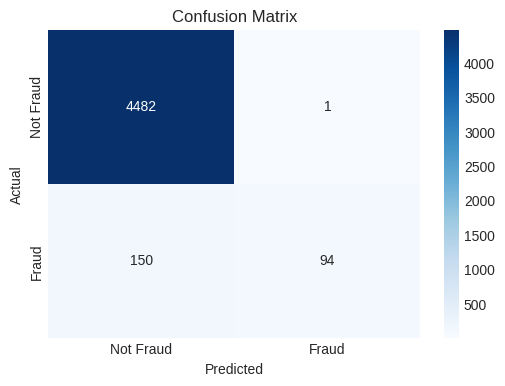

In [247]:
# -------------------------
# 1. Dataset class
# -------------------------
class FraudDataset(Dataset):
    def __init__(self, X, y):
        self.X = X.values.astype("float32")
        self.y = y.values.astype("float32")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

# -------------------------
# 2. Model definition
# -------------------------
class FraudNet(nn.Module):
    def __init__(self, input_dim):
        super(FraudNet, self).__init__()
        self.model = nn.Sequential(
          nn.Linear(input_dim, 256),
          nn.BatchNorm1d(256),
          nn.PReLU(),
          nn.Dropout(0.4),

          nn.Linear(256, 128),
          nn.BatchNorm1d(128),
          nn.PReLU(),
          nn.Dropout(0.3),

          nn.Linear(128, 64),
          nn.BatchNorm1d(64),
          nn.PReLU(),
          nn.Dropout(0.2),

          nn.Linear(64, 32),
          nn.PReLU(),

          nn.Linear(32, 1),
          nn.Sigmoid()
      )

    def forward(self, x):
        return self.model(x)

# -------------------------
# 3. Weighted BCE loss & sampler
# -------------------------
fraud_ratio = y_train.mean()
non_fraud_ratio = 1 - fraud_ratio
class_weights = torch.tensor([non_fraud_ratio, fraud_ratio], dtype=torch.float32)

def weighted_bce(preds, targets):
    weight = targets * class_weights[1] + (1 - targets) * class_weights[0]
    bce = nn.BCELoss(reduction='none')(preds, targets)
    return (bce * weight).mean()

# -------------------------
# 4. K-Fold training
# -------------------------
full_train_ds = FraudDataset(X_train, y_train)
test_ds = FraudDataset(X_test, y_test)

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"\n===== Fold {fold+1}/{n_splits} =====")

    train_subset = Subset(full_train_ds, train_idx)
    val_subset   = Subset(full_train_ds, val_idx)

    # Weighted sampler for oversampling fraud
    sample_weights = np.where(y_train.iloc[train_idx]==1, 1.0/fraud_ratio, 1.0/non_fraud_ratio)
    sample_weights = torch.tensor(sample_weights, dtype=torch.float32)
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_subset, batch_size=64, sampler=sampler)
    val_loader   = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = FraudNet(input_dim=X_train.shape[1])
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_loss = float("inf")
    patience = 5
    patience_counter = 0
    n_epochs = 50

    for epoch in range(n_epochs):
        # Train
        model.train()
        train_loss = 0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            preds = model(xb).squeeze()
            loss = weighted_bce(preds, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                preds = model(xb).squeeze()
                val_loss += weighted_bce(preds, yb).item()

        print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        # Early stopping
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), os.path.join(model_dir, f"best_fraud_nn_fold{fold+1}.pt"))
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    # Evaluate fold
    model.load_state_dict(torch.load(os.path.join(model_dir, f"best_fraud_nn_fold{fold+1}.pt")))
    model.eval()
    y_proba_nn, y_true_nn = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb).squeeze()
            y_proba_nn.extend(preds.numpy())
            y_true_nn.extend(yb.numpy())
    y_proba_nn = np.array(y_proba_nn)
    y_true_nn = np.array(y_true_nn)
    y_pred_nn = (y_proba_nn > 0.2).astype(int)  # lower threshold for higher recall

    fold_results.append((y_true_nn, y_pred_nn, y_proba_nn))

# -------------------------
# 5. Train final model
# -------------------------
train_loader_full = DataLoader(full_train_ds, batch_size=64, shuffle=True)

nn_model = FraudNet(input_dim=X_train.shape[1])
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    nn_model.train()
    for xb, yb in train_loader_full:
        optimizer.zero_grad()
        preds = nn_model(xb).squeeze()
        loss = weighted_bce(preds, yb)
        loss.backward()
        optimizer.step()

# -------------------------
# 6. Evaluate on test set
# -------------------------
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

nn_model.eval()
y_proba_nn, y_true_nn = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        preds = nn_model(xb).squeeze()
        y_proba_nn.extend(preds.numpy())
        y_true_nn.extend(yb.numpy())

y_proba_nn = np.array(y_proba_nn)
y_true_nn = np.array(y_true_nn)
y_pred_nn = (y_proba_nn > 0.2).astype(int)  # lower threshold for higher recall

evaluate_model(
    model=None,
    X_test=X_test,
    y_test=y_true_nn,
    y_pred=y_pred_nn,
    y_proba=y_proba_nn
)


## Ensemble

Best weight NN: 0.70, XGB: 0.30, Best threshold: 0.27
Best F1 Score: 0.6233

--- Classification Report ---
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.98      4483
       Fraud       0.92      0.47      0.62       244

    accuracy                           0.97      4727
   macro avg       0.95      0.73      0.80      4727
weighted avg       0.97      0.97      0.97      4727


--- ROC AUC / AUPRC ---
AUPRC Score: 0.6186
ROC AUC Score: 0.8555


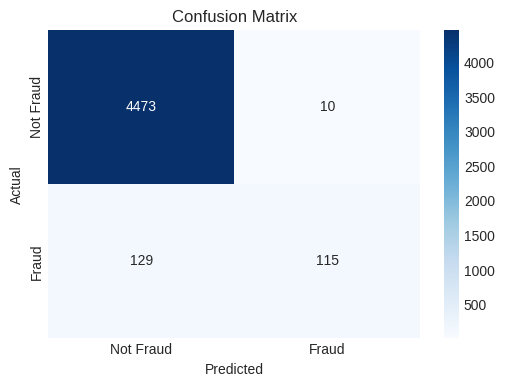

In [251]:
# Define search space
weights = np.linspace(0, 1, 21)       # 0.00 to 1.00 step=0.05
thresholds = np.linspace(0.05, 0.50, 46)   # 0.05 to 0.50 step=0.01

best_score = -np.inf
best_w_nn = None
best_threshold = None
best_preds = None

for w_nn in weights:
    w_xgb = 1 - w_nn
    y_proba_ensemble = w_nn * y_proba_nn + w_xgb * y_proba_xgb

    for t in thresholds:
        y_pred_ensemble = (y_proba_ensemble > t).astype(int)
        # You can optimize for any metric, e.g., F1, recall, or PR-AUC
        score = f1_score(y_true_nn, y_pred_ensemble)

        if score > best_score:
            best_score = score
            best_w_nn = w_nn
            best_threshold = t
            best_preds = y_pred_ensemble

print(f"Best weight NN: {best_w_nn:.2f}, XGB: {1-best_w_nn:.2f}, Best threshold: {best_threshold:.2f}")
print(f"Best F1 Score: {best_score:.4f}")

# Evaluate best ensemble
y_proba_best = best_w_nn * y_proba_nn + (1-best_w_nn) * y_proba_xgb
evaluate_model(
    model=None,
    X_test=X_test,
    y_test=y_true_nn,
    y_pred=best_preds,
    y_proba=y_proba_best,
    target_names=['Not Fraud', 'Fraud']
)

# Simulating Advanced Scenarios

## Intelligent Adversarial Attack Simulation: "The Chameleon"

In [249]:
fraud_indices = y_test[y_test == True].index
if not fraud_indices.empty:
    # Get original raw data for the entire test set
    X_test_raw_df = df.loc[X_test.index].copy()

    # Simulate the multi-pronged "Chameleon" attack on the raw data
    print("-> Attacker uses matching shipping/billing addresses.")
    X_test_raw_df.loc[fraud_indices, 'shipping_billing_mismatch'] = 0

    print("-> Attacker avoids suspicious night hours.")
    X_test_raw_df.loc[fraud_indices, 'is_night_transaction'] = 0
    X_test_raw_df.loc[fraud_indices, 'hour_of_day'] = 14 # A "safe" hour

    print("-> Attacker normalizes transaction amount to category average.")
    # This is the most powerful attack: make the amount look normal for its category
    X_test_raw_df.loc[fraud_indices, 'transaction_amount'] = X_test_raw_df.loc[fraud_indices, 'category_avg_amount']
    # Recalculate features that depend on the modified transaction_amount
    X_test_raw_df['amount_vs_category_avg'] = X_test_raw_df['transaction_amount'] / (X_test_raw_df['category_avg_amount'] + 1e-6)
    X_test_raw_df['amount_to_account_age_ratio'] = X_test_raw_df['transaction_amount'] / (X_test_raw_df['account_age_days'] + 1)

    # Now, process this attacked raw data EXACTLY as we did the original data
    X_attacked_processed = X_test_raw_df.drop(columns=features_to_drop)
    X_attacked_processed = pd.get_dummies(X_attacked_processed, columns=categorical_features, drop_first=True)
    X_attacked_processed_aligned, _ = X_attacked_processed.align(X_train, axis=1, fill_value=0)
    X_attacked_processed_aligned[numerical_features] = scaler.transform(X_attacked_processed_aligned[numerical_features])

    # Predict using the final trained model
    y_prob_final_series = pd.Series(y_proba_xgb, index=y_test.index)
    prob_before_attack = y_prob_final_series[fraud_indices]

    prob_after_attack = best_model_xgb.predict_proba(X_attacked_processed_aligned)[:, 1]
    prob_after_attack_series = pd.Series(prob_after_attack, index=X_test.index)[fraud_indices]

    print("\nImpact of 'Chameleon' Adversarial Attack on Fraud Probability Predictions:")
    attack_summary = pd.DataFrame({'Prob_Before_Attack': prob_before_attack, 'Prob_After_Attack': prob_after_attack_series})
    attack_summary['Prob_Reduction'] = attack_summary['Prob_Before_Attack'] - attack_summary['Prob_After_Attack']

    print(attack_summary.sort_values('Prob_Reduction', ascending=False).head(10))

    avg_prob_before = prob_before_attack.mean()
    avg_prob_after = prob_after_attack_series.mean()
    print(f"\nAverage fraud probability dropped from {avg_prob_before:.2f} to {avg_prob_after:.2f} due to the intelligent attack.")

    threshold = 0.5
    evaded_count = ((prob_before_attack >= threshold) & (prob_after_attack_series < threshold)).sum()
    total_fraud = len(fraud_indices)
    print(f"Evasion Rate: {evaded_count}/{total_fraud} ({evaded_count/total_fraud:.1%}) of fraudulent transactions would now be misclassified as legitimate.")

else:
    print("No fraud cases in test set to simulate attack.")

-> Attacker uses matching shipping/billing addresses.
-> Attacker avoids suspicious night hours.
-> Attacker normalizes transaction amount to category average.

Impact of 'Chameleon' Adversarial Attack on Fraud Probability Predictions:
       Prob_Before_Attack  Prob_After_Attack  Prob_Reduction
17459            0.977175           0.151408        0.825767
19523            0.971991           0.164062        0.807928
15391            0.955731           0.194382        0.761349
21541            0.951165           0.216419        0.734745
2879             0.937297           0.207223        0.730075
18564            0.982670           0.261592        0.721078
5794             0.985596           0.308555        0.677041
6753             0.884149           0.251023        0.633126
10534            0.784470           0.229481        0.554990
21883            0.984494           0.436295        0.548199

Average fraud probability dropped from 0.69 to 0.75 due to the intelligent attack.
Evasion R

## Human-in-the-Loop & LLM Agent Simulation

In [250]:
def generate_case_summary(transaction_index, full_df, y_prob_series, top_features_list):
    trans_info = full_df.loc[transaction_index]
    fraud_prob = y_prob_series[transaction_index] * 100

    summary = f"""
    ===================================================
    LLM-Generated Case Summary for Fraud Analyst
    ===================================================
    Transaction ID: {trans_info['transaction_id']} | Customer ID: {trans_info['customer_id']}
    Fraud Probability: {fraud_prob:.1f}% -> Recommendation: {'High Priority Review' if fraud_prob > 60 else 'Low Priority'}

    Transaction Context:
    - Amount: ${trans_info['transaction_amount']:.2f} for '{trans_info['product_category']}'
    - Time: Hour {trans_info['hour_of_day']} ({'Night' if trans_info['is_night_transaction'] else 'Day'})
    - Customer Age: {trans_info['customer_age']} | Account Age: {trans_info['account_age_days']} days

    Key Risk Factors (Model Insights):
    -------------------------------------------
    """
    for feature in top_features_list:
        value = trans_info.get(feature) # Use the raw value for interpretability
        if value is not None and value != 0:
            if 'mismatch' in feature and value == 1:
                summary += f"- CRITICAL: Shipping and Billing Addresses DO NOT MATCH.\n"
            elif 'time_since' in feature and value < 3600: # Less than an hour
                 summary += f"- VELOCITY ALERT: Repeat transaction in {value/60:.1f} minutes.\n"
            elif 'amount_vs' in feature and value > 2.0:
                summary += f"- VALUE ANOMALY: Transaction amount is {value:.1f}x the typical average.\n"
            else:
                 summary += f"- {feature.replace('_', ' ').title()}: {value:.2f}\n"

    summary += "==================================================="
    return summary

if not fraud_indices.empty:
    # Find the transaction with the highest fraud probability in the test set
    high_risk_transaction_index_in_test = y_proba_xgb.argmax()
    high_risk_original_index = y_test.index[high_risk_transaction_index_in_test]

    y_prob_series = pd.Series(y_proba_xgb, index=y_test.index)

    case_report = generate_case_summary(high_risk_original_index, df, y_prob_series, top_features_xgb)
    print(case_report)
else:
    print("No fraud cases in test set to generate sample report.")


    LLM-Generated Case Summary for Fraud Analyst
    Transaction ID: 9a7ead0b-fd11-4bba-838f-f83a6bb3fd4f | Customer ID: becce2d6-4a18-48e2-8436-a9ee6a99ef82
    Fraud Probability: 99.8% -> Recommendation: High Priority Review

    Transaction Context:
    - Amount: $2796.15 for 'electronics'
    - Time: Hour 18 (Day)
    - Customer Age: 19 | Account Age: 4 days

    Key Risk Factors (Model Insights):
    -------------------------------------------
    - Hour Of Day: 18.00
- Account Age Days: 4.00
- Transaction Hour: 4.00
- Amount To Account Age Ratio: 559.23
- Transaction Amount: 2796.15
- VALUE ANOMALY: Transaction amount is 12.3x the typical average.
- Customer Age: 19.00
- Quantity: 4.00
- Day Of Week: 4.00
- Location Frequency: 1.00
